# Under- and overfitting, model selection

## Preliminaries

In the first set of exercises you had to implement the training and evaluation of the linear regression and $k$-NN methods from scratch in order to practice your `numpy` skills. From this set of exercises onward, you can use the implementations provided in `scikit-learn` or other higher-level libraries. We start this set of exercises by demonstrating some of the features of `scikit-learn`.

For example, implementation of linear regression model fitting with an analytical solution for the parameters is provided by the class `sklearn.linar_model.LinearRegression`. You can train a linear regression model in the following way:

In [1]:
import numpy as np
from sklearn import datasets, linear_model

# load the diabetes dataset
diabetes = datasets.load_diabetes()

# use only one feature
X = diabetes.data[:, np.newaxis, 2]
y = diabetes.target

# split the data into training/testing sets
X_train = X[:-20]
X_test = X[-20:]

# split the targets into training/testing sets
y_train = y[:-20]
y_test = y[-20:]

# create linear regression object
model = linear_model.LinearRegression()

# train the model using the training dataset
model.fit(X_train, y_train)

LinearRegression()

Let's visualize the training dataset and the learned regression model.

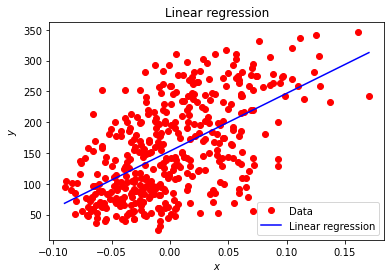

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(X_train, y_train, 'r.', markersize=12)
X_edge = np.array([np.min(X_train, 0), np.max(X_train, 0)])
plt.plot(X_edge, model.predict(X_edge), 'b-')
plt.legend(('Data', 'Linear regression'), loc='lower right')
plt.title('Linear regression')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

Once trained, the model can be used to make predictions on the test data:

In [3]:
# Make predictions using the testing dataset
prediction = model.predict(X_test)

The next step (not shown here) is to evaluate the performance of the trained model.

Note that the `scikit-learn` interface works by first initializing an object from the class that implements the machine learning model (linear regression in this case) and then fitting the initialized model using the data in the training set. Finally, the trained (fitted) model can be used to make predictions on unseen data. In fact, all models implemented in this library follow the same *initialize-fit-predict* programming interface. For example, a $k$-NN classifier can be trained in the following way:

In [4]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors

breast_cancer = datasets.load_breast_cancer()

X = breast_cancer.data
y = breast_cancer.target

# make use of the train_test_split() utility function instead
# of manually dividing the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)

# initialize a 3-NN classifier
model = neighbors.KNeighborsClassifier(n_neighbors=3)

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)

Note that the features in the breast cancer dataset have different scales (some have on average very small absolute values, and some very large), which means that the distance metric used by $k$-NN will me dominated by the features with large values. You can use any of the number of feature transformation methods implemented in `scikit-learn` to scale the features. For example, you can use the `sklearn.preprocessing.StandardScaler` method to transform all features to a have a zero mean and unit variance:

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

The scaler has its own parameters which are the means and standard deviations of the features estimated from the training set. If you train a model with the scaled features, you will have to remember to also apply the scaling transformation every time you make a prediction on new unseen and unscaled data. This is somewhat prone to error. One option for making the code more robust is to create a processing pipeline that includes the scaling and $k$-NN models in a sequence:

In [6]:
from sklearn.pipeline import Pipeline

knn = neighbors.KNeighborsClassifier(n_neighbors=3)

model = Pipeline([
                 ("scaler", scaler),
                 ("knn", knn)
                ])

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)


If you are curious, more information about the design of the `scikit-learn` application programming interface (API) can be found [in this paper](https://arxiv.org/pdf/1309.0238.pdf). 

## Exercises

### Bias-variance decomposition

Show that the mean squared error of the estimate of a parameter can be decomposed into an expression that includes both the bias and variance (Eq. 5.53-5.54 in "Deep learning" by Goodfellow et al.). 

### Polynomial regression

For this exercise we will be using generated data to better show the effects of the different polynomial orders.
The data is created using the make_polynomial_regression function.

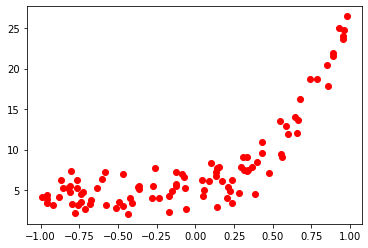

In [7]:
%matplotlib inline

def generate_dataset(n=100, degree=1, noise=1, factors=None):
    # Generates a dataset by adding random noise to a randomly
    # generated polynomial function.
    
    x = np.random.uniform(low=-1, high=1, size=n)
    
    factors = np.random.uniform(0, 10, degree+1)
    
    y = np.zeros(x.shape)
    
    for idx in range(degree+1):
        y += factors[idx] * (x ** idx)

    # add noise
    y += np.random.normal(-noise, noise, n)
    
    return x, y

# load generated data
np.random.seed(0)

X, y = generate_dataset(n=100, degree=4, noise=1.5)

plt.plot(X, y, 'r.', markersize=12)

Implement polynomial regression using the `sklearn.preprocessing.PolynomialFeatures` transformation. Using the `sklearn.grid_search.GridSearchCV` class, perform a grid search of the polynomial order hyperparameter space with cross-validation and report the performance on an independent test set.

Plot a learning curve that show the validation accuracy as a function of the polynomial order. 

<p><font color='#770a0a'>Which models have a high bias, and which models have high variance? Motivate your answer.</font><p>
    
Repeat this experiment, this time using the diabetes dataset instead of the generated data.

### ROC curve analysis
A common method to evaluate binary classifiers is the receiver operating characteristic (ROC) curve. Similar to the week one practicals, implement a $k$-NN classifier on the breast cancer dataset, however, his time use the $k$-NN pipeline from the preliminary. Train the model for different values of $k$ and evaluate their respective performance with an ROC curve, use the `sklearn.metrics.roc_curve` function.

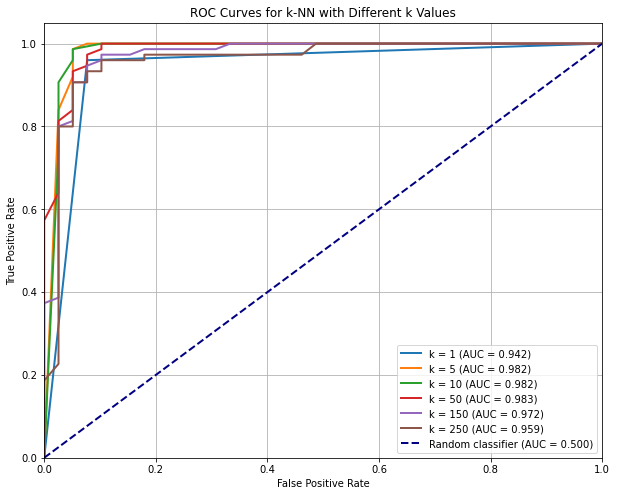

In [12]:
# Import function to plot ROC curves for different k values
import sys
sys.path.append('code/')
from knn_roc import plot_knn_roc_curves

# split into training and test set without stratification to see effect of distribution shift with a different random state
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

# make a list of the k-values you want to test
k_values = [1, 5, 10, 50, 150, 250]

plot_knn_roc_curves(X_train, X_test, y_train, y_test, k_values)

***Answer:*** The ROC curve analysis shows consistently high AUC values across all tested k-values (from k=1 to k=300), with a minimum AUC of 0.94. This indicates that the classifier performs excellent in distinguishing positive and negative cases, regardless of the specific k-value chosen. Since all k-values yield similarly strong performance, using the the model trained with k=10 can be a good option. The number of neighbours used is large enough to reduce sensitivity to noise and prevent overfitting, but small enough to capture meaningful patterns in the data without underfitting. This choice ensures robust performance while maintaining the model's ability to make accurate predictions on new data.

AUC values for k from 1 to 20:
k	AUC
---------------
1	0.9415
10	0.9819
8	0.9815
50	0.9834
75	0.9815
150	0.9718
200	0.9668


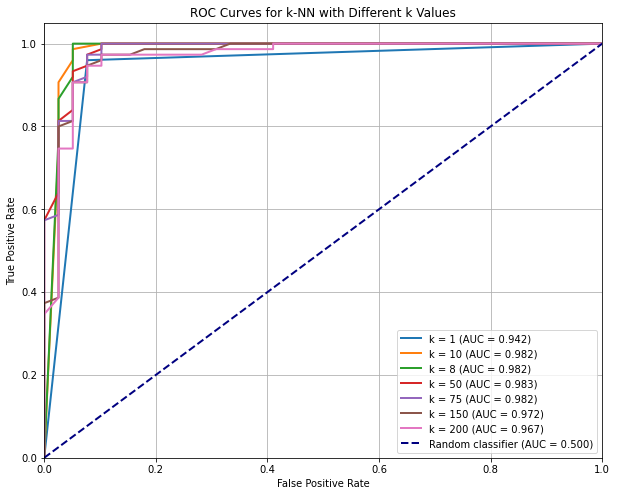

In [13]:
# Import necessary libraries
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Define different k values to test (1 to 20)
#k_values = list(range(1, 21))
k_values = [1, 10, 8, 50, 75, 150, 200]

# Create a figure for the ROC curves
plt.figure(figsize=(10, 8))

# Print header for AUC values
print("AUC values for k from 1 to 20:")
print("k\tAUC")
print("-" * 15)

# Iterate through different k values
for k in k_values:
    # Create a k-NN classifier with the current k value
    knn_exercise = neighbors.KNeighborsClassifier(n_neighbors=k)
    
    # Create the pipeline with scaler and classifier
    model_knn = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", knn_exercise)
    ])
    
    # Train the model using the training data
    model_knn.fit(X_train, y_train)
    
    # Get prediction probabilities for the positive class
    # CHANGED: Use predict_proba instead of predict to get probabilities
    y_score = model_knn.predict_proba(X_test)[:, 1]
    
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
    
    # Calculate the AUC (Area Under Curve)
    roc_auc = auc(fpr, tpr)
    
    # Print AUC value for this k
    print(f"{k}\t{roc_auc:.4f}")
    
    # Plot the ROC curve for this k value
    plt.plot(fpr, tpr, lw=2, label=f'k = {k} (AUC = {roc_auc:.3f})')

# Plot the diagonal line (random classifier baseline)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier (AUC = 0.500)')

# Configure the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for k-NN with Different k Values')
plt.legend(loc="lower right")
plt.grid(True)

# Display the plot
plt.show()

### $F_1$ score and Dice similarity coefficient

The Dice similarity coefficient is a very popular evaluation measure for image segmentation applications. Assuming that $A$ is the ground truth segmentation of an object represented as a binary image, and $B$ is the binary output of an image segmentation method, the Dice similarity coefficient is computed as:

$\text{Dice}(A,B) = \frac{2|A\cap B|}{|A| + |B|}$

where $|\cdot|$ represents the cardinality of the objects (e.g. $|A|$ is the number of non-zero pixels in the ground truth segmentation).

For example, the Dice similarity can be computed in the following way:

0.3402777777777778


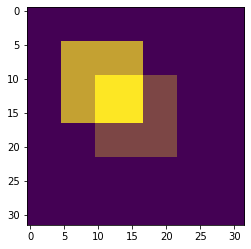

In [10]:
# generate some test objecys
A = np.zeros((32, 32))
A[10:-10, 10:-10] = 1
B = np.zeros((32, 32))
B[5:-15, 5:-15] = 1

dice = 2*np.sum(A*B)/(np.sum(A)+np.sum(B))

# display the results
plt.plot()
plt.imshow(A)
plt.imshow(B, alpha=0.7)

print(dice)

<p><font color='#770a0a'>Show that the $F_1$ score, which is the harmonic mean of precision and recall, is equivalent to the Dice similarity coefficient</font><p>